# 🏳️‍🌈 LGBTQ

# Carga de librerias necesarias

In [43]:
import pandas as pd
import nltk
import stanza
from tqdm.notebook import tqdm
from datetime import datetime as dt
import transformers
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import re
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Inicialización

In [17]:
sns.set_style('darkgrid')
stanza.download('es')
# nltk.download() <- Si no has bajado los paquetes de NLTK descomentar esta linea
# Cargamos las Stop Words de Español
with open('../Otros/spanish-stop-words.txt') as f:
    lines = set(f.read().splitlines())

lines.union(['http', 'https', '@', 'com'])

# Pipeline de Stanza
nlp = stanza.Pipeline('es', processor='tokenize,sentiment')

2023-12-08 15:54:55 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-12-08 15:54:58 INFO: Loading these models for language: es (Spanish):
| Processor    | Package         |
----------------------------------
| tokenize     | ancora          |
| mwt          | ancora          |
| pos          | ancora_charlm   |
| lemma        | ancora_nocharlm |
| constituency | combined_charlm |
| depparse     | ancora_charlm   |
| sentiment    | tass2020        |
| ner          | conll02         |

2023-12-08 15:54:58 INFO: Using device: cpu
2023-12-08 15:54:58 INFO: Loading: tokenize
2023-12-08 15:55:01 INFO: Loading: mwt
2023-12-08 15:55:01 INFO: Loading: pos
2023-12-08 15:55:02 INFO: Loading: lemma
2023-12-08 15:55:02 INFO: Loading: constituency
2023-12-08 15:55:03 INFO: Loading: depparse
2023-12-08 15:55:03 INFO: Loading: sentiment
2023-12-08 15:55:03 INFO: Loading: ner
2023-12-08 15:55:04 INFO: Done loading processors!


# Carga de los datos

In [2]:
# Cargamos los datos del Excel
xls = pd.ExcelFile("../../Datasets/social_media.xlsx", engine='openpyxl')

In [3]:
# Nombre de las hojas del excel
xls.sheet_names

['Post 1',
 'Post 2',
 'Post 3',
 'Post 4',
 'Post 5',
 'Post 6',
 'Post 7',
 'Post 8',
 'Post 9',
 'Post 10',
 'Post 11',
 'Post 12',
 'Post 13',
 'Post 14',
 'Post 15',
 'Post 16',
 'Post 17',
 'Post 18',
 'Post 19',
 'Post 20',
 'Post 21',
 'Post 22',
 'Post 23',
 'Post 24',
 'Post 25',
 'Post 26',
 'Post 27',
 'Post 28',
 'Post 29',
 'Post 30',
 'Post 31',
 'Post 32',
 'Post 33',
 'Post 34',
 'Post 35',
 'Post 36',
 'Post 37',
 'Post 38',
 'Post 39',
 'Post 40',
 'Post 41',
 'Post 42',
 'Post 43',
 'Post 44',
 'Post 45',
 'Post 46',
 'Post 47',
 'Post 48',
 'Post 49',
 'Post 50',
 'Post 51',
 'Post 52',
 'Post 53',
 'Post 54',
 'Post 55',
 'Post 56',
 'Post 57',
 'Post 58',
 'Post 59',
 'Post 60',
 'Post 61',
 'Post 62']

In [4]:
# Cargamos el primero para ver como se cargan los datos
df_test = pd.read_excel(xls, 'Post 1', names=['URL', 'Autor', 'Fecha', 'Contenido', 'Es_Principal', 'Likes', 'Compartido', 'Num_Comentarios'])
df_test.Fecha = pd.to_datetime(df_test.Fecha)
df_test.head()

,URL,Autor,Fecha,Contenido,Es_Principal,Likes,Compartido,Num_Comentarios
0,https://twitter.com/c4jimenez/status/171486912...,@c4jimenez,2023-10-18 23:00:00,"EL VIOLADOR SERIAL, DETENIDO!\nAsí llegó a CDM...",1,215,42,9
1,https://twitter.com/29Toninho/status/171486974...,@29Toninho,2023-10-18 23:03:00,El violador romántico les dejaba cartas 📝🤮🤮🤮🤮🤮...,0,2,0,0


In [5]:
# Cargamos los datos de todas las hojas
dfs = []
for sheet in xls.sheet_names:
    print(f"Cargando datos de la hoja: {sheet}")
    df = pd.read_excel(xls, sheet, names=['URL', 'Autor', 'Fecha', 'Contenido', 'Es_Principal', 'Likes', 'Compartido', 'Num_Comentarios'])
    df['sheet'] = sheet
    df['language'] = 'es'
    print(f"Finalizo carga de datos de la hoja: {sheet}")
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

Cargando datos de la hoja: Post 1
Finalizo carga de datos de la hoja: Post 1
Cargando datos de la hoja: Post 2
Finalizo carga de datos de la hoja: Post 2
Cargando datos de la hoja: Post 3
Finalizo carga de datos de la hoja: Post 3
Cargando datos de la hoja: Post 4
Finalizo carga de datos de la hoja: Post 4
Cargando datos de la hoja: Post 5
Finalizo carga de datos de la hoja: Post 5
Cargando datos de la hoja: Post 6
Finalizo carga de datos de la hoja: Post 6
Cargando datos de la hoja: Post 7
Finalizo carga de datos de la hoja: Post 7
Cargando datos de la hoja: Post 8
Finalizo carga de datos de la hoja: Post 8
Cargando datos de la hoja: Post 9
Finalizo carga de datos de la hoja: Post 9
Cargando datos de la hoja: Post 10
Finalizo carga de datos de la hoja: Post 10
Cargando datos de la hoja: Post 11
Finalizo carga de datos de la hoja: Post 11
Cargando datos de la hoja: Post 12
Finalizo carga de datos de la hoja: Post 12
Cargando datos de la hoja: Post 13
Finalizo carga de datos de la hoja:

In [6]:
# Primeras filas del Dataframe
df_all.head(10)

,URL,Autor,Fecha,Contenido,Es_Principal,Likes,Compartido,Num_Comentarios,sheet,language
0,https://twitter.com/c4jimenez/status/171486912...,@c4jimenez,18-10-2023 11:00 PM,"EL VIOLADOR SERIAL, DETENIDO!\nAsí llegó a CDM...",1,215,42,9,Post 1,es
1,https://twitter.com/29Toninho/status/171486974...,@29Toninho,18-10-2023 11:03 PM,El violador romántico les dejaba cartas 📝🤮🤮🤮🤮🤮...,0,2,0,0,Post 1,es
2,https://m.facebook.com/groups/707238376800762/...,Anónimo,22/03/23 4:49 PM,"Hola, querida comunidad!\n\n‼️‼️NECESITO de su...",1,15,0,16,Post 2,es
3,https://m.facebook.com/groups/707238376800762/...,Issac Sánchez,03/09/23 8:24 PM,Buen día a Todxs. \n\nCon el permiso del grupo...,1,3,0,9,Post 3,es
4,https://fb.watch/nZ4_axu9q_/?mibextid=Nif5oz,NMAS,02/10/23 5:42 PM,Una mujer trans fue atacada por dos sujetos y ...,1,5.5 mil,99,2.8 mil,Post 4,es
5,https://m.facebook.com/groups/707238376800762/...,alba López,04/10/23 8:29 AM,"Hola, disculpen, alguien me pudiera recomendar...",1,2,0,5,Post 5,es
6,https://m.facebook.com/groups/707238376800762/...,Guillermo LB,06/05/23 9:58 PM,¿Qué procedimiento o a qué abogadx nos recomie...,1,182,0,92,Post 6,es
7,https://m.facebook.com/story.php?story_fbid=pf...,de pisa corre Tv,18/0923 11:15 AM,"#LauraGlover, mujer trans que fue víctima de #...",1,872,24,749,Post 7,es
8,https://m.facebook.com/story.php?story_fbid=pf...,Perla Vergara,2023-11-05 07:00:00,Que onda pregunte de la vacuna del papiloma y ...,1,11,0,4,Post 8,es
9,https://m.facebook.com/story.php?story_fbid=pf...,Julio Cesar Rea Velasco,06/10/23 4:14PM,A todos mis amig@s y conocid@s les pido que co...,1,1,2,3,Post 9,es


In [7]:
# Tail
df_all.tail(10)

,URL,Autor,Fecha,Contenido,Es_Principal,Likes,Compartido,Num_Comentarios,sheet,language
88,https://x.com/variopinto69/status/172238767563...,Variopinto69,08-11-2023 16:56 PM,PERSONAS DESAPARECIDAS LGBT+ 🏳️‍⚧️🏳️‍🌈\n\nEn M...,1,5,4,0,Post 54,es
89,https://x.com/v3nuzflytr4p/status/172073359366...,v3nuzflytr4p,04-11-2023 3:23PM,Dato curioso: La Virgen de Guadalupe fue cread...,1,1,0,0,Post 55,es
90,https://twitter.com/CarlRamirezA/status/172014...,CarlRamirezA,02-11-2023 12:30PM,"El es Jesús Ociel Baena, magistrado del Tribun...",1,1000,371,414,Post 56,es
91,https://twitter.com/Hilarin17118234/status/172...,Hilarin17118234,2023-11-02 12:59:00,La Virgen de Guadalupe y la religión católica ...,0,142,9,10,Post 56,es
92,https://x.com/SuaGyvez/status/1720429205450543...,SuaGyvez,03-11-2023 7:14PM,"La violencia, crímenes de odio, transfeminicid...",1,0,0,1,Post 57,es
93,https://twitter.com/hectoragmr/status/17206187...,hectoragmr,3-11-2023 7:47PM,"No, Christian. Vivir dentro del “ambiente gay”...",1,1000,103,57,Post 58,es
94,https://www.facebook.com/share/8HyVqnawBdbhVq1...,DnewsOk,09-11-2023 10;30AM,"✍️🏻 A través de un documento doctrinal, el Vat...",1,1,0,0,Post 59,es
95,https://www.facebook.com/share/dk5pw2FKbecMh6M...,Cromosoma x,2023-10-18 12:00:00,Es alarmante ver un aumento en los crímenes de...,1,2,0,0,Post 60,es
96,https://www.facebook.com/share/fapSLZPr8W7xzcw...,Antólogia,10-10-2023 12;00 PM,Urgente: el aspirante a la presidencia de Méxi...,NaN,8,3,1,Post 61,es
97,https://vm.tiktok.com/ZMjTvToS1/,Juan Pablo Delgado,2023-06-22 00:00:00,gritos de odio en la alcaldia cuactemoc,1,2546,37,187,Post 62,es


In [8]:
# Info General
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   URL              93 non-null     object
 1   Autor            93 non-null     object
 2   Fecha            93 non-null     object
 3   Contenido        93 non-null     object
 4   Es_Principal     93 non-null     object
 5   Likes            94 non-null     object
 6   Compartido       97 non-null     object
 7   Num_Comentarios  97 non-null     object
 8   sheet            98 non-null     object
 9   language         98 non-null     object
dtypes: object(10)
memory usage: 7.8+ KB


In [9]:
# Revisamos el número de filas por columna
df_all.count()

URL                93
Autor              93
Fecha              93
Contenido          93
Es_Principal       93
Likes              94
Compartido         97
Num_Comentarios    97
sheet              98
language           98
dtype: int64

In [10]:
# Check valores faltantes
df_all.isna().sum()

URL                5
Autor              5
Fecha              5
Contenido          5
Es_Principal       5
Likes              4
Compartido         1
Num_Comentarios    1
sheet              0
language           0
dtype: int64

In [11]:
# Tomamos los valores sin NA
df_all = df_all[df_all.URL.notna()]

In [12]:
# Hacemos un respaldo del Dataframe
data = df_all.copy()

In [13]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0 to 97
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   URL              93 non-null     object
 1   Autor            93 non-null     object
 2   Fecha            93 non-null     object
 3   Contenido        93 non-null     object
 4   Es_Principal     91 non-null     object
 5   Likes            92 non-null     object
 6   Compartido       92 non-null     object
 7   Num_Comentarios  92 non-null     object
 8   sheet            93 non-null     object
 9   language         93 non-null     object
dtypes: object(10)
memory usage: 8.0+ KB


> No hay datos nulos 😊

# Procesamiento

In [14]:
# Copiamos el contenido original a una nueva columna en caso de que se modifique la columna original
data['contenido_original'] = df['Contenido']
# Obtenemos las palabras por contenido
data['Palabras'] = data.Contenido.apply(lambda x:re.findall(r'\w+', x ))
# Contamos el total de palabras por publicacion
data['Total_Palabras'] = data.Contenido.apply(len)

# Cloud Words

In [15]:
# Unimos la variable contenido en un solo texto
texto = ' '.join(data.Contenido)

In [18]:
# Probamos generando la nube de palabras con el color default y uno blanco
cloud = WordCloud(stopwords=lines, max_font_size=50, max_words=100, background_color="white").generate(texto)
cloud2 = WordCloud(stopwords=lines, max_font_size=50, max_words=100).generate(texto)

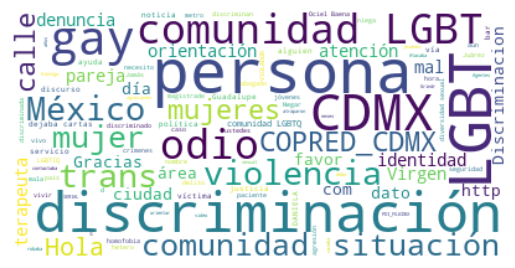

In [19]:
# Mostramos la imagen con matplotlib
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

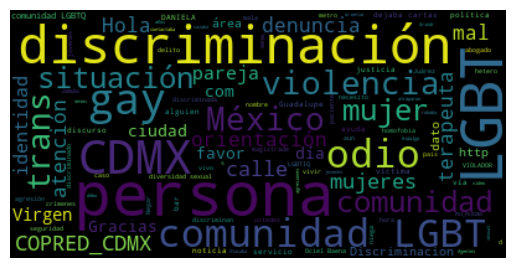

In [20]:
# Mostramos la imagen 2 con matplotlib
plt.imshow(cloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
from PIL import Image
import cv2

# Creamos la mascara para la imagen
mask = cv2.imread("../Mask/apple.png")
hand = cv2.imread("../Mask/hand.png")
hand2 = cv2.bitwise_not(hand)

In [22]:
# Creamos la imagen utilizando la mascara
cloud_mask = WordCloud(stopwords=lines,
mask=mask,
max_font_size=90,
max_words=2000,
contour_width=1,
background_color="white").generate(texto)

image_colors = ImageColorGenerator(mask)

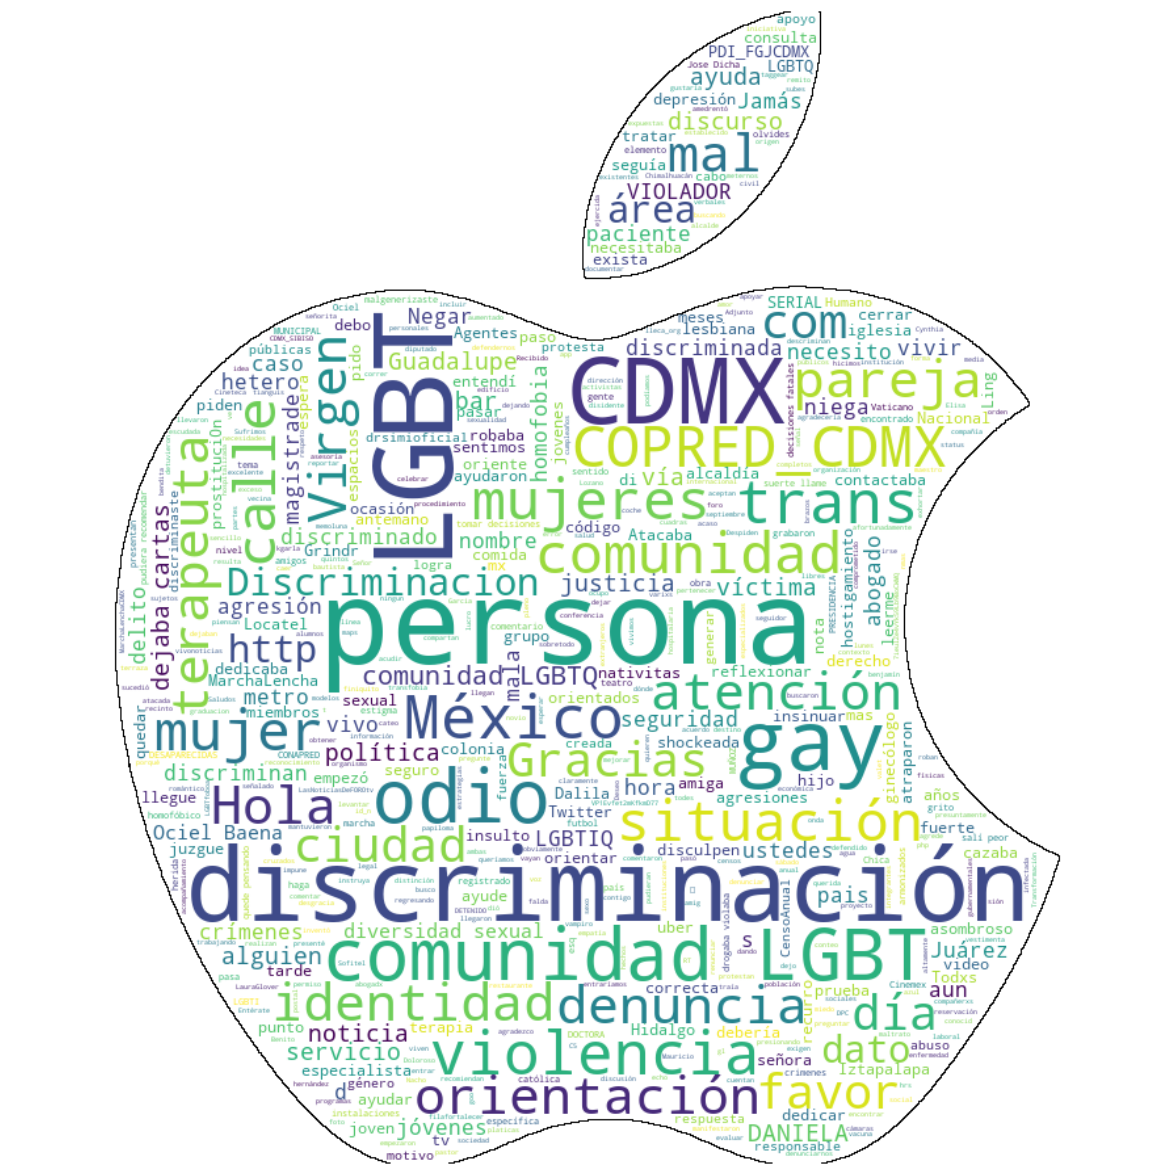

In [23]:
# Mostramos la imagen
fig = plt.figure(figsize=(15,15))
plt.imshow(cloud_mask, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
# Guardamos la imagen en un archivo
cloud_mask.to_file("../Images/cloud_words_img_manzana.png")

In [25]:
cloud_mask2 = WordCloud(stopwords=lines,
mask=hand2,
max_font_size=90,
max_words=2000,
contour_width=1,
background_color="white").generate(texto)


image_colors2 = ImageColorGenerator(hand)

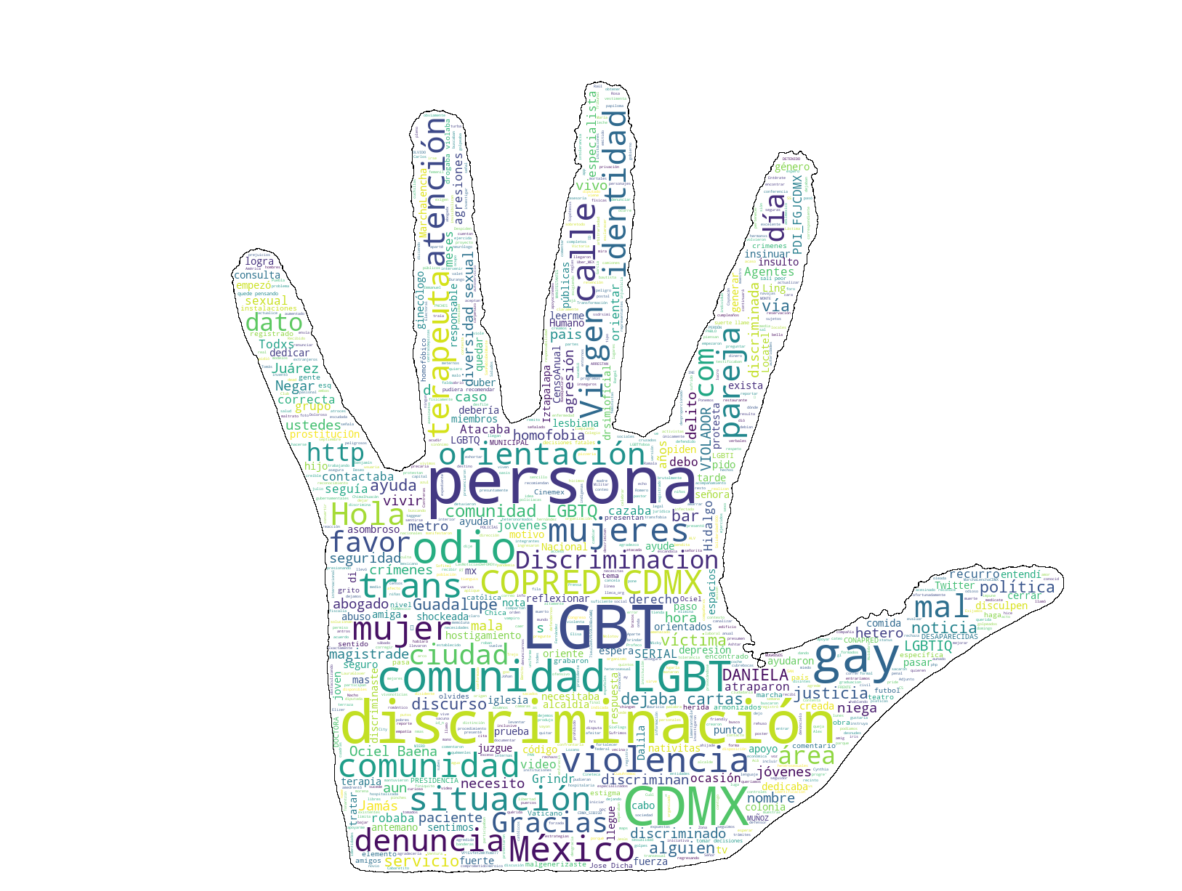

In [26]:
fig = plt.figure(figsize=(15,15))
plt.imshow(cloud_mask2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
cloud_mask2.to_file("../Images/cloud_words_img_mano.png")

# Transformers

Un transformer no es el robot interestelar que lucha contra los Decepticon (😔). 

Se trata de una arquitectura de redes neuronales que en estos momentos se considera estado del arte en modelos secuenciales. El Transformer, en NLP, resuelve tareas Seq2Seq sin los problemas de dependencias largas que presentan las LSTM o RNN.

In [28]:
# Creamos un objeto de Pipeline que ya aplica el modelo
from transformers import pipeline

pipe = pipeline("text-classification", model="karina-aquino/spanish-sentiment-model")

In [29]:
# Probando con el Pipeline
texto = """
Con tus donativos también ayudas a darle refugio a personas LGBT+ en situación de calle, ya que con ello nos permites pagar servicios como luz, agua, gas, etc que son indispensables para Casa Lleca, puedes encontrar más info aquí: https://www.animalpolitico.com/genero-y-diversidad/albergues-para-personas-en-situacion-de-calle-cdmx-2
"""
pipe('Hoy fue un buen dia')

[{'label': '5 stars', 'score': 0.6350911855697632}]

In [30]:
# Cargamos el modelo directamente
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("karina-aquino/spanish-sentiment-model")
model = AutoModelForSequenceClassification.from_pretrained("karina-aquino/spanish-sentiment-model")

In [31]:
# Probando con el tokenizer y model
sample1 = tokenizer(texto, return_tensors='pt')
result_1 = model(**sample1)
scores = result_1[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.02008792,
 'roberta_neu': 0.03720066,
 'roberta_pos': 0.08755515}

In [32]:
pipe('Hoy fue un mal dia')

[{'label': '2 stars', 'score': 0.4116329550743103}]

In [33]:
sample2 = tokenizer('Hoy fue un mal dia', return_tensors='pt')
result_2 = model(**sample2)
scores2 = result_2[0][0].detach().numpy()
scores2 = softmax(scores2)
scores_dict2 = {
    'roberta_neg' : scores2[0],
    'roberta_neu' : scores2[1],
    'roberta_pos' : scores2[2]
}
scores_dict2

{'roberta_neg': 0.35428584,
 'roberta_neu': 0.41163296,
 'roberta_pos': 0.16876422}

In [34]:
texto = data.loc[0].Contenido
texto

'EL VIOLADOR SERIAL, DETENIDO!\nAsí llegó a CDMX Jose Dicha\nAtacaba a jovenes de la comunidad LGBT 🏳️\u200d🌈 \nLos contactaba y cazaba en \n@Grindr\n\nLos drogaba, violaba y robaba.\nAntes de irse, les dejaba cartas.\nAgentes d \n@PDI_FGJCDMX\n lo buscaron por meses.\nHoy lo atraparon en Hidalgo.'

In [35]:
pipe(texto)

[{'label': '1 star', 'score': 0.4474566578865051}]

In [36]:
def polarity_scores_roberta(example):
    """Esta funcion regresa el score por contenido en un diccionario"""
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        's_neg' : scores[0],
        's_neu' : scores[1],
        's_pos' : scores[2]
    }
    return scores_dict

In [37]:
# Extrayendo el sentimiento por publicación
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Contenido']
        myid = i
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Interrumpido en el indice {myid}')

  0%|          | 0/93 [00:00<?, ?it/s]

In [38]:
# Creamos un DF de los resultados
result_df = pd.DataFrame(res).T
result_df

,s_neg,s_neu,s_pos
0,0.447457,0.387921,0.097973
1,0.420403,0.454877,0.086664
2,0.182991,0.374568,0.213459
3,0.082401,0.213390,0.216316
4,0.317792,0.450736,0.172516
...,...,...,...
93,0.283564,0.443009,0.153360
94,0.026225,0.085962,0.341911
95,0.596340,0.294591,0.054299
96,0.366459,0.481803,0.107738


In [40]:
# Agregamos los resultados al dataframe data
data['roberta_neg'] = result_df.s_neg
data['roberta_neu'] = result_df.s_neu
data['roberta_pos'] = result_df.s_pos

In [41]:
# Lista con las clases
clases = ['Negativo', 'Neutral', 'Positivo'] # Negativo, Neutral, Positivo

In [44]:
# Obteniendo la clase del 1 elemento
clases[np.argmax(data.loc[0, ['roberta_neg', 'roberta_neu', 'roberta_pos']].values)]

'Negativo'

In [45]:
# Creando columna sentiment
data['sentiment'] = [clases[np.argmax(item)] for item in data[['roberta_neg', 'roberta_neu', 'roberta_pos']].values]
data['sentiment_id'] = [np.argmax(item) for item in data[['roberta_neg', 'roberta_neu', 'roberta_pos']].values]

## Nube de palabras por sentimiento

In [46]:
# filtramos
df_negativos = data[data.sentiment == 'Negativo']
df_neutral = data[data.sentiment == 'Neutral']
df_positivos = data[data.sentiment == 'Positivo']

In [48]:
def crear_nube_palabras_por_sentimiento(df: pd.DataFrame, sentiment: str, color: str, maskimg):
    """Esta funcion genera la nube de palabras"""
    txt = ' '.join(df.Contenido)
    cloud_img = WordCloud(stopwords=lines,
        mask=maskimg,
        max_font_size=90,
        max_words=2000,
        contour_width=1,
        background_color=color
    ).generate(txt)

    fig = plt.figure(figsize=(15,15))
    plt.imshow(cloud_img, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    cloud_img.to_file(f"../Images/{sentiment}_nube.jpg")


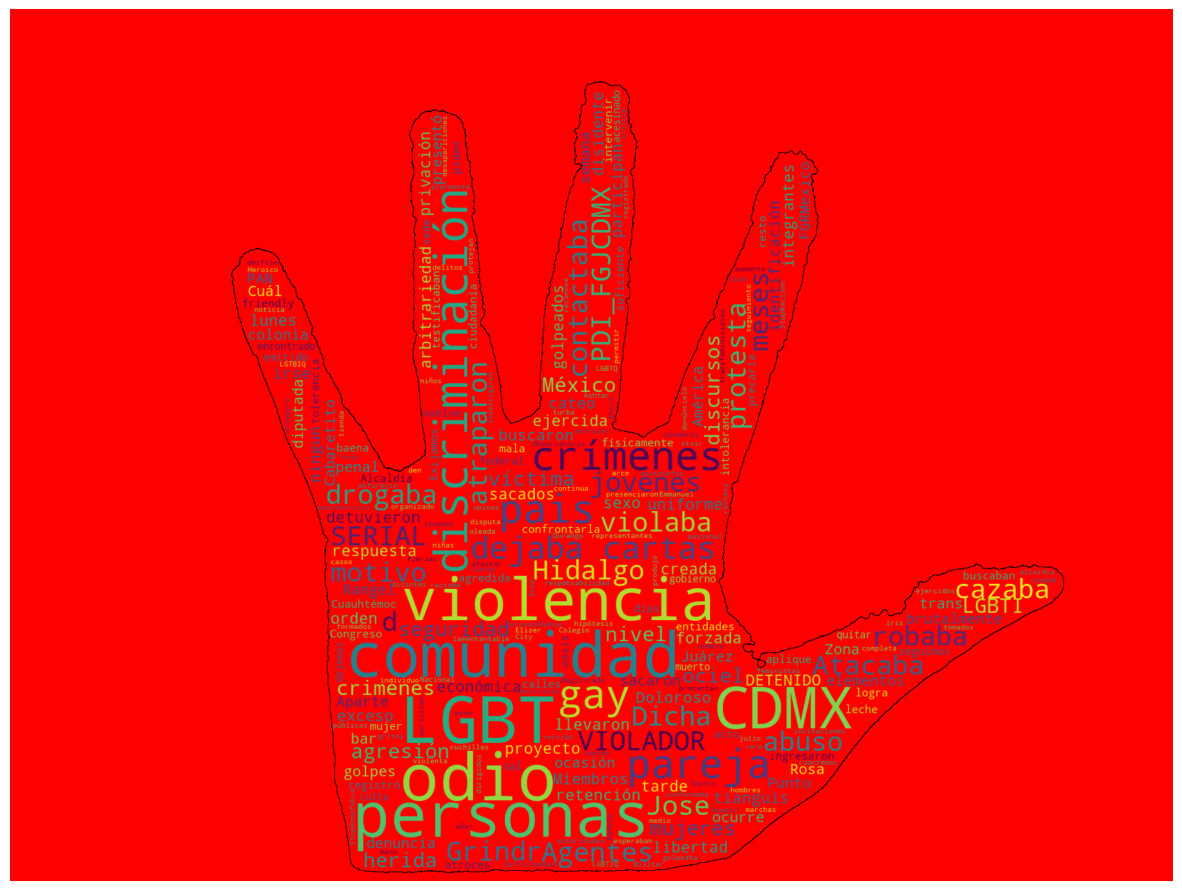

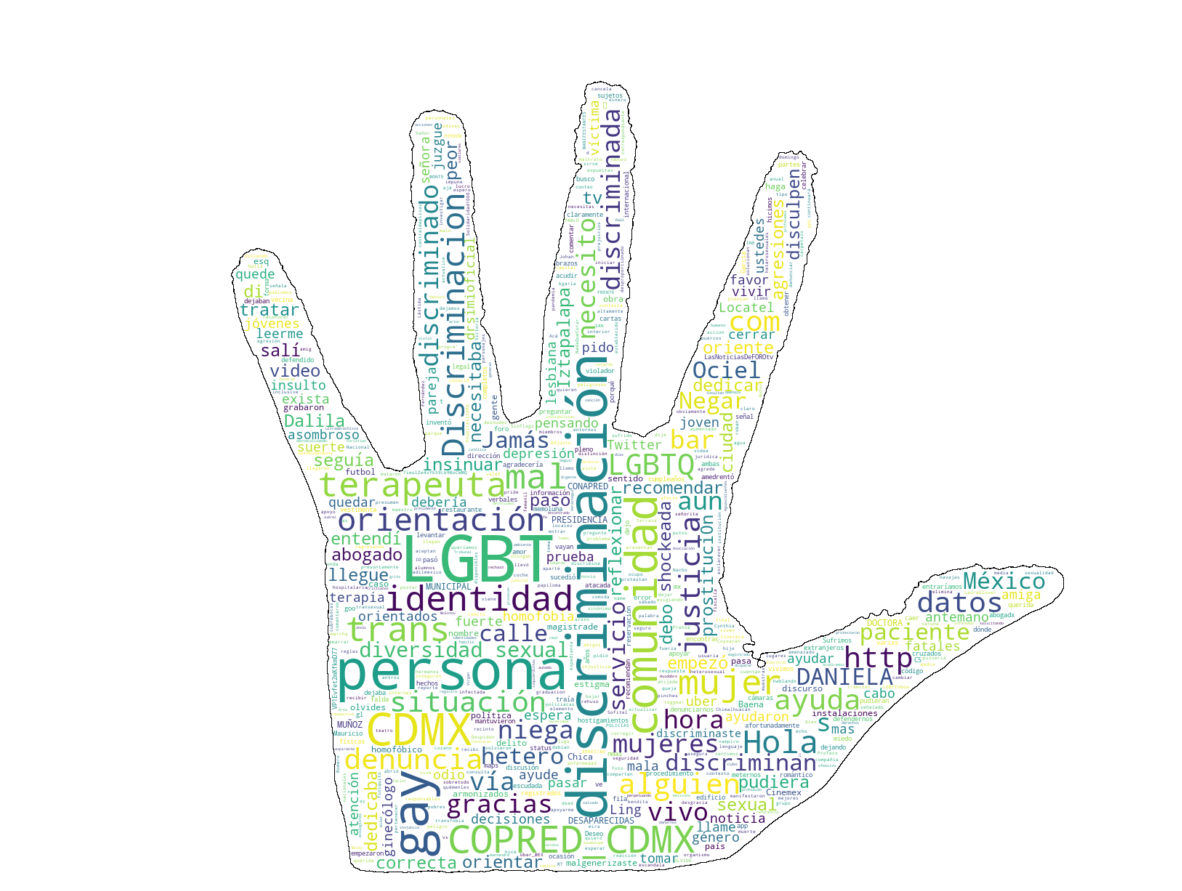

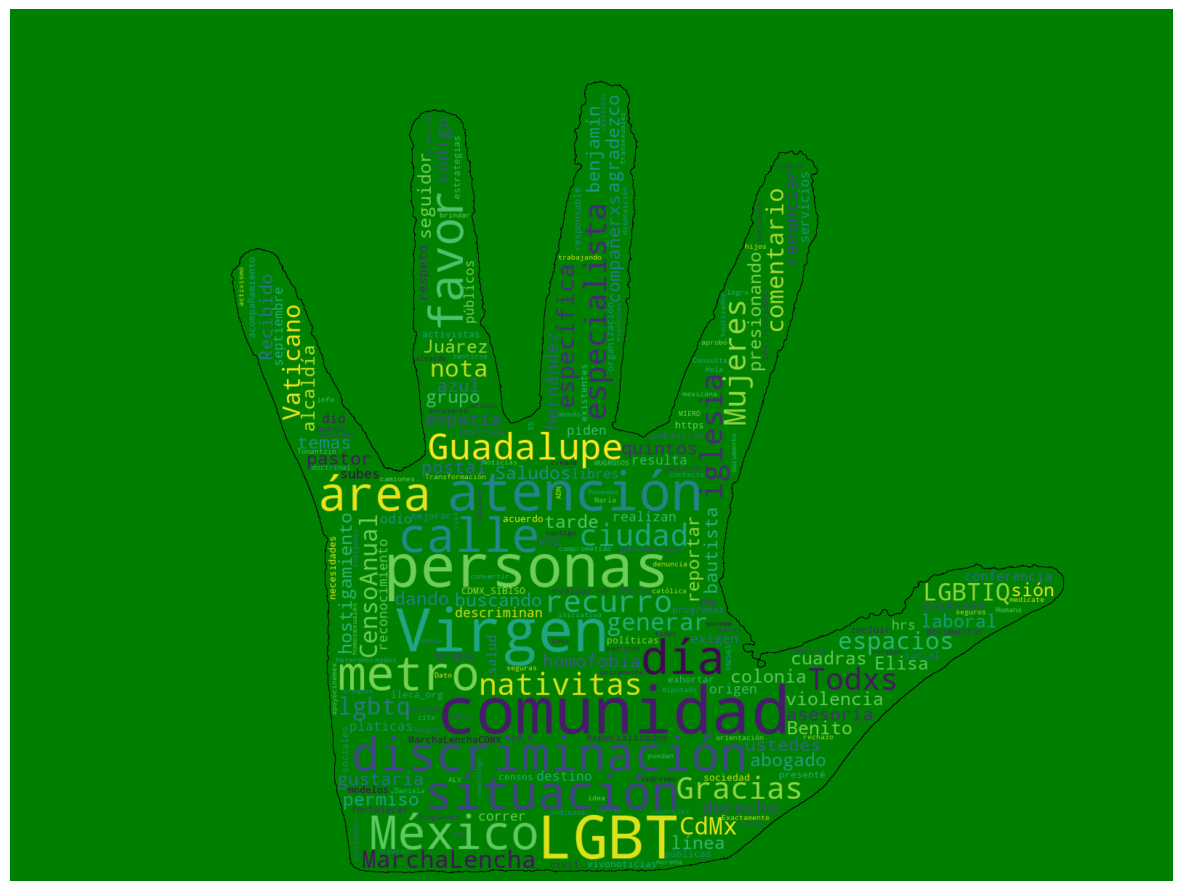

In [49]:
# Creamos las imagenes x sentimiento
crear_nube_palabras_por_sentimiento(df_negativos, 'negativo', 'red', maskimg=hand2)
crear_nube_palabras_por_sentimiento(df_neutral, 'neutral', 'white', maskimg=hand2)
crear_nube_palabras_por_sentimiento(df_positivos, 'positivo', 'green', maskimg=hand2)

In [ ]:
# Descargamos el diccionario de palabras en espáñol
!python -m spacy download es

In [50]:
import spacy
import numpy as np
spacy_nlp = spacy.load('es_core_news_sm') # En el paso anterior nos indico que debemos usar este nuevo

import string
punct = string.punctuation

from spacy.lang.es.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS) # listado de stopwords


In [51]:
token_col = []
lemma_col = []
# Generando columnas: Palabras_Token, Palabras_Lemma
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Contenido']
        res = nlp(text)
        tokens = []
        lemma = []
        for idx, sentence in enumerate(res.sentences):
            for word in sentence.words:
                if word.text not in stopwords and word.text not in punct:
                    tokens.append(word.text)
                    lemma.append(word.lemma)
                    # print(f'word: {word.text} \tlemma: {word.lemma}')
        token_col.append(tokens)
        lemma_col.append(tokens)
    except RuntimeError:
        print(f"Ocurrio un error el id {i}")

  0%|          | 0/93 [00:00<?, ?it/s]

In [52]:
data['Palabras_Token'] = token_col
data['Palabras_Lemma'] = lemma_col

# Modelando

In [53]:
def text_data_cleaning(sentence):
        """Genera la tokenizacion"""
        doc = spacy_nlp(sentence)

        tokens = [] # list of tokens
        for token in doc:
            if token.lemma_ != "-PRON-":
                temp = token.lemma_.lower().strip()
            else:
                temp = token.lower_
            tokens.append(temp)

        cleaned_tokens = []
        for token in tokens:
            if token not in stopwords and token not in punct:
                cleaned_tokens.append(token)
        return cleaned_tokens

In [54]:
def text_data_cleaning2(sentence):
        """Genera la tokenizacion con Stanza"""
        res = nlp(sentence)

        tokens = [] # list of tokens
        for idx, sentence in enumerate(res.sentences):
            for word in sentence.words:
                if word.text not in stopwords and word.text not in punct:
                    tokens.append(word.text)
                    tokens.append(word.lemma)

        return set(tokens)

In [55]:
def tokenize(text):
    """Otra funcion para tokenizar :P"""
    stem = nltk.stem.SnowballStemmer('spanish')
    text = text.lower()

    for token in nltk.word_tokenize(text):
        if token in string.punctuation: continue
        yield stem.stem(token)


In [56]:
# Probando la funcion de limpieza y tokenización
text_data_cleaning("""
Estaba la pájara pinta
Sentada en su verde limón
Con el pico recoge la rama
Con la rama cortaba la flor
""")
# Esto quitara las comas y signos

['pájar',
 'pinta',
 'sentada',
 'verde',
 'limón',
 'pico',
 'recoger',
 'rama',
 'rama',
 'cortar',
 'flor']

In [57]:
# Probando la funcion de limpieza y tokenización
text_data_cleaning2("""
Estaba la pájara pinta
Sentada en su verde limón
Con el pico recoge la rama
Con la rama cortaba la flor
""")
# Esto quitara las comas y signos

{'Con',
 'Estaba',
 'Sentada',
 'con',
 'cortaba',
 'cortar',
 'estar',
 'flor',
 'limón',
 'pico',
 'pinta',
 'pájara',
 'rama',
 'recoge',
 'recoger',
 'sentado',
 'verde'}

In [58]:
tokenize("""
Estaba la pájara pinta
Sentada en su verde limón
Con el pico recoge la rama
Con la rama cortaba la flor
""")

<generator object tokenize at 0x000001C4C9F71FC0>

### Vectorizando TF-IDF

In [59]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [60]:
# Preparamos nuestra variable TfidfVectorizer con nuestra función para tokenizar
tfidf = TfidfVectorizer(tokenizer=text_data_cleaning)
tfidf2 = TfidfVectorizer(tokenizer=text_data_cleaning2)
tfidf3 = TfidfVectorizer(tokenizer=tokenize)

### Seleccionando las columnas

In [61]:
# Seleccionando X & Y
X = data['Contenido']
Y = data['sentiment_id']

### Separando los datos de entrenamiento y test

In [62]:
# Separamos la data de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0, shuffle=42)

In [64]:
x_train.shape, x_test.shape
# Tenemos 65 items para entrenamiento y 28 para test

((65,), (28,))

### Entrenando

In [65]:
# Creamos nuestra instancia de LinearSVC
classifier = LinearSVC()
classifier2 = LinearSVC()
classifier3 = LinearSVC()

In [66]:
# Creamos un item de Pipeline para llevar el proceso de Tokenización y luego ejecutar el clasificador
pipeline = Pipeline([('tfidf', tfidf), ('clf', classifier)])
pipeline2 = Pipeline([('tfidf', tfidf2), ('clf', classifier2)])

In [67]:
# Aplicamos el metodo fit de LinearSVC
pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001C4C9F942C0>)),
                ('clf', LinearSVC())])

In [68]:
# Aplicamos el metodo fit de LinearSVC
pipeline2.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning2 at 0x000001C4C9F96480>)),
                ('clf', LinearSVC())])

> Nota ya no se uso el classifier3 ya que no es compatible con el metodo de tokenización 3.

### Revisamos el performance del modelo

In [69]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [71]:
y_pred = pipeline.predict(x_test)
y_pred2 = pipeline2.predict(x_test)

In [72]:
# confusion_matrix 1
confusion_matrix(y_test, y_pred)

array([[ 2,  4,  0],
       [ 1, 15,  0],
       [ 0,  5,  1]], dtype=int64)

In [73]:
# confusion_matrix 2
confusion_matrix(y_test, y_pred2)

array([[ 2,  4,  0],
       [ 0, 16,  0],
       [ 0,  5,  1]], dtype=int64)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.62      0.94      0.75        16
           2       1.00      0.17      0.29         6

    accuracy                           0.64        28
   macro avg       0.76      0.48      0.49        28
weighted avg       0.71      0.64      0.59        28



In [75]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.64      1.00      0.78        16
           2       1.00      0.17      0.29         6

    accuracy                           0.68        28
   macro avg       0.88      0.50      0.52        28
weighted avg       0.79      0.68      0.61        28



In [76]:
"El accuracy es de {}".format(round(accuracy_score(y_test, y_pred)*100,2))

'El accuracy es de 64.29'

In [79]:
"El accuracy es de {}%".format(round(accuracy_score(y_test, y_pred2)*100, 0))

'El accuracy es de 68.0%'

### Guardamos nuestro modelo

In [ ]:
# Guardamos nuestro modelo
import joblib
joblib.dump(pipeline, '../Models/sentiment_lgbtq_model.pkl')
joblib.dump(pipeline2, '../Models/sentiment_lgbtq_model2.pkl')

### Probando la predicción

In [80]:
prediction = pipeline.predict(["Amo a la comunidad LGBTQ"])
prediction

array([1], dtype=int64)

In [81]:
prediction = pipeline2.predict(["Amo a la comunidad LGBTQ"])
prediction

array([1], dtype=int64)

## Utilizando NaiveBayes

In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [83]:
# Creamos un objeto vectorizer
vectorizer = CountVectorizer(strip_accents='ascii', stop_words=stopwords, lowercase=False)
vectorizer

CountVectorizer(lowercase=False,
                stop_words=['haya', 'mucho', 'solas', 'ella', 'mío', 'sería',
                            'usas', 'haciendo', 'cuándo', 'míos', 'podemos',
                            'antes', 'para', 'conmigo', 'quién', 'allí',
                            'algunos', 'hicieron', 'él', 'o', 'tus', 'dicen',
                            'ir', 'paìs', 'respecto', 'llegó', 'sabemos',
                            'tendrán', 'unos', 'vuestro', ...],
                strip_accents='ascii')

In [84]:
# Ahora probamos usando directamente la clase
Z = data['sentiment']

In [85]:
# Separamos los datos del entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.25)

In [88]:
# Generamos la bolsa de palabras utilizando CountVectorizer 
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [89]:
X_train_bow.shape, Y_train.shape

((69, 857), (69,))

In [90]:
X_test_bow.shape, Y_test.shape

((24, 857), (24,))

In [91]:
# Clasificador
clf = MultinomialNB()

In [92]:
# Entrenamientos
clf.fit(X_train_bow, Y_train)

MultinomialNB()

In [94]:
accuracy = clf.score(X_test_bow, Y_test)
f"El accuracy con MultinomialNB es {round(accuracy*100, 2)}%"

'El accuracy con MultinomialNB es 58.33%'

In [96]:
prediction = clf.predict(X_test_bow)
prediction

array(['Negativo', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negativo',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Negativo', 'Neutral', 'Neutral', 'Negativo'],
      dtype='<U8')

# Utilizando Redes Neuronales


In [97]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TextVectorization, GRU, Embedding
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.activations import softmax

In [98]:
vocab_size = 1000
text_vec_layer = TextVectorization(max_tokens=vocab_size) #, vocabulary=X.values)
text_vec_layer.adapt(X)

In [ ]:
# Nota: da error en python 3.12, debe ejecutarse en Colab.
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(3, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, epochs=2)

In [99]:
loss, accuracy = model.evaluate(X_test, Y_test)

print(f"El accuracy con Tensorflow es {round(accuracy*100, 1)}%")

'El accuracy con Tensorflow es 37.3%'

# Conclusión

En conclusión, el procesamiento del lenguaje natural es un área de la inteligencia artificial donde debemos mantener actualizado el registro de los datos, con el fin de mantener un histórico de las etiquetas y poder ir mejorando la clasificación. Es por ello, que en temas de clasificación en NLP debemos ir manteniendo un historico, para que el algoritmo de ML tenga